# Process and Plot _siextentn_ from CMIP6 historical experiments

## Introduction
This notebook describes how to download, process and plot northern hemisphere sea ice extent from CMIP6 historical experiments.  I only include the first ensemble member from each model.  An alternative approach would be to use all ensemble members and calculate the model ensemble mean for models with multiple ensembles.

Data are processed into a single `pandas DataFrame` and written to a csv file `siextentn.CMIP6.historical.csv`.  A plot is generated and saved as `siextentn.CMIP6.historical.png`.

## Data
I use model files downloaded from `esfg-node.llnl.gov` for `project=CMIP6`, `variable_id=siextentn`, `table_id=SImon`, `experiment_id=historical`, and `member_id=r1i1p1f1` (the first ensemble member).  A `wget` script can be generated and downloaded by copy and pasting the following URL into a browser. 

https://esgf-node.llnl.gov/esg-search/wget?limit=500&project=CMIP6&variable_id=siextentn&table_id=SImon&experiment_id=historical&member_id=r1i1p1f1

This automatically downloads a `wget` script.  See https://www.earthsystemcog.org/projects/cog/doc/wget for further details.

You will need an ESGF login and OpenID to get the data.  This is easily set up.

In [152]:
import glob
import os
import sys
import calendar

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Directory structure and processing
Data for each model are contained in one or more files.  The download script places are the files in the directory in which the script was run.  Running the following cell tidys things up placing files in a directory tree by `variable`, `table`, `model`, `experiment`, and `ensemble-member`.  

In [43]:
DATADIR = '/home/apbarret/Data/CMIP6'  # Change this to the location in which you ran the wget script

def clean_up_downloaded_files(datadir):
    '''Moves ESGF CMIP6 files into a directory structure'''
    filelist = glob.glob(os.path.join(datadir, '*.nc'))
    if filelist:
        for f in filelist:
            variable, table, model, experiment, member, grid, time_range = f.split('_')
            dirpath = os.path.join(datadir, variable, table, model, experiment, member)
            try:
                os.makedirs(dirpath)
            except FileExistsError:
                pass  # It is OK is directory path exists
            except:
                print('Unexpected error: ', sys.exc_info()[0])
                raise
            os.rename(f, os.path.join(dirpath, f))
    else:
        print(f'No files found in {datadir}: nothing to be done')
            
clean_up_downloaded_files(DATADIR)

No files found in /home/apbarret/Data/CMIP6: nothing to be done


Northern hemisphere sea ice extent files are time series of scalars; one data point represent sea ice extent in millions of square kilometers.  I use `xarray` to read files for a single model ensemble member.  These are then place in a `pandas DataFrame`.  To facilitate this, I generate a dictionary with models as keys and lists of files as values.

In [50]:
models = [os.path.basename(d) for d in glob.glob(os.path.join(DATADIR, 'siextentn/SImon/*'))]
catalog = {}
for m in models:
    catalog[m] = glob.glob(os.path.join(DATADIR, 'siextentn', 'SImon', m, 'historical', 'r1i1p1f1', '*.nc'))

Next I read the models using `xarray`.  Some models (e.g. CESM2) use a non-standard calendar with no leap year.  These data are y xarray as `CFTimeIndex` object.  To facilitate plotting and allow data to be combined, I convert `time` indices from `CFTimeIndex` to `datetime64`.  Time series are then concatenated into a `pandas` `DataFrame`.  The time conversion may not be necessary but I get errors when trying to plot using `xarray.DataFrame.siextentn.plot()`.  Timestamps for each month vary between models.  Some models use day 15 of a month as the central date, others use day 16.  When time series are concatenated into a single table, dates do not line up. So I use a helper function `_normalize_datetime` to set timestamps for all time steps to day 15 of each month.

The `pandas` `Dataframe` containing all models is written to a `csv` file.

In [106]:
def read_ensemble(model):
    '''Reads file for a given model ensemble into an xarray Dataset'''
    ds = xr.open_mfdataset(catalog[model], combine='by_coords')
    if isinstance(ds.indexes['time'], xr.CFTimeIndex):
        ds['time'] = ds.indexes['time'].to_datetimeindex()
    return ds


def _normalize_datetime(TimeIndex):
    import datetime as dt
    return [dt.datetime(y, m, 15) for y, m in zip(ts.index.year, ts.index.month)]


def dataset2timeseries(ds):
    '''Converts ds.siextent to a pandas timeseries.  Times are set to midnight 00:00:00'''
    ts = ds.siextentn.squeeze().to_series()
    ts.index = _normalize_datetime(ts.index)
    return ts
    

In [128]:
import warnings
warnings.simplefilter("ignore")  # Brute force way to ignore RuntimeWarning about converting from noleap calendar

series = []
for m in models:
    ds = read_ensemble(m)
    ts = dataset2timeseries(ds)
    ts.name = m
    series.append(ts)
warnings.simplefilter("default")  # Turn warnings back on

df = pd.concat(series, axis=1)
df.to_csv(os.path.join(DATADIR, 'siextentn', 'SImon', 'siextentn.SImon.CMIP6.historical.csv'))

The `csv` file is read using `pandas.read_csv` as follows.

In [124]:
df = pd.read_csv(os.path.join(DATADIR, 'siextentn', 'SImon', 'siextentn.SImon.CMIP6.historical.csv'),
                 index_col=0, header=0, parse_dates=True)
df.head()

,MPI-ESM1-2-HR,ACCESS-CM2,INM-CM4-8,CESM2-WACCM-FV2,MPI-ESM-1-2-HAM,CESM2-WACCM,ACCESS-ESM1-5,MRI-ESM2-0,AWI-CM-1-1-MR,CESM2-FV2,CESM2,MPI-ESM1-2-LR,INM-CM5-0,NorESM2-LM,NorESM2-MM,IPSL-CM6A-LR
1850-01-15,14.524994,15.400951,16.555944,14.800295,13.759284,14.373685,14.901051,14.435524,15.848625,14.464868,14.361740,15.367842,16.584423,14.099590,14.148132,16.124708
1850-02-15,15.057966,16.383898,17.993713,15.304046,14.711484,14.819675,15.802239,15.492135,17.196268,14.896288,15.053534,16.449190,17.948383,14.428174,14.753365,17.646687
1850-03-15,15.522406,17.105118,18.558460,15.387679,15.301144,15.225739,16.476192,15.889923,17.148650,15.399905,15.573739,16.917143,19.090279,14.314548,14.805148,17.595330
1850-04-15,15.146090,16.801937,18.207396,15.451011,14.589539,15.264583,16.144020,15.126458,16.392406,15.327523,15.279046,16.015171,18.509250,13.895150,14.015628,16.752907
1850-05-15,13.729387,15.766763,16.393532,14.638363,13.233748,14.512105,15.310038,13.832352,14.708080,14.551849,14.347973,13.972161,16.096630,12.263137,12.435895,14.313114


A "quick and dirty" plot of northern hemisphere September sea ice extent is made. 

In [177]:
df.shape[1]

16

In [180]:
it = itertools.product(['-', '--'], mcolors.TABLEAU_COLORS)
color, symbol = zip(*[next(it) for i in range(df.shape[1])])
print(color)
print(symbol)

('-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--')
('tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown')


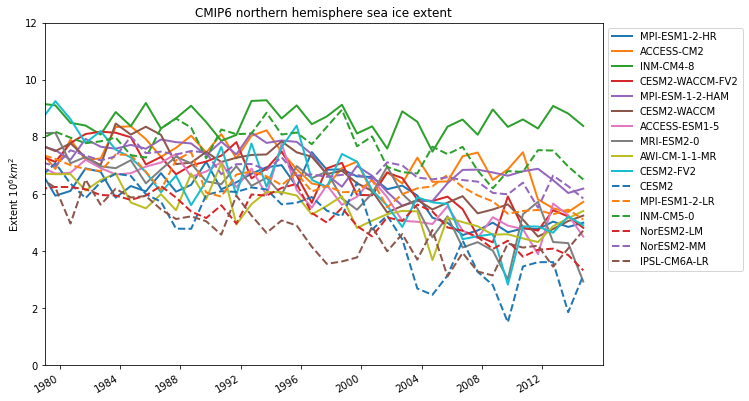

In [188]:
# Make color and symbols for models
it = itertools.product(['-', '--'], mcolors.TABLEAU_COLORS)
style, color = zip(*[next(it) for i in range(df.shape[1])])

fig, ax = plt.subplots(figsize=(10, 7))
df[df.index.month == 9].plot(ax = ax, linewidth=2, style=list(style), color=list(color))
ax.set_ylim(0, 12)
ax.set_xlim('1979-01-01', '2015-12-31');
ax.set_title("CMIP6 northern hemisphere sea ice extent")
ax.set_ylabel("Extent $10^6 km^2$");
ax.legend(loc="upper left", bbox_to_anchor=(1,1))
fig.savefig(os.path.join(DATADIR, 'siextentn', 'SImon', 'siextentn.SImon.CMIP6.historical.png'))

The mean seasonal cycle of sea ice extent for 1979 to 2014 is show below.

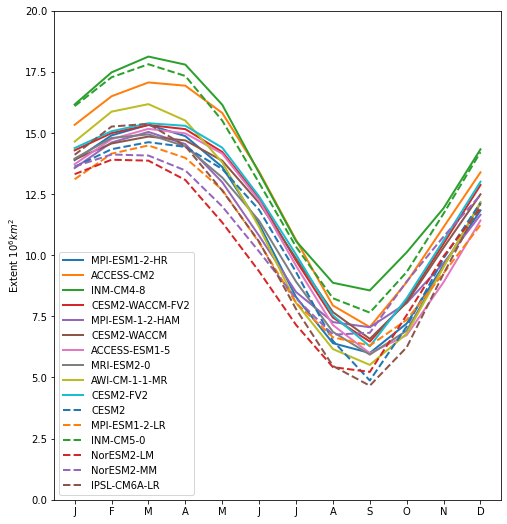

In [189]:
dfClim = df['1979':'2014'].groupby(df['1979':'2014'].index.month).mean()
fig, ax = plt.subplots(figsize=(8,9))
dfClim.plot(ax=ax, linewidth=2, style=list(style), color=list(color))
ax.set_ylim(0, 20)
ax.set_ylabel("Extent $10^6 km^2$")
ax.set_xticks(range(1,13))
ax.set_xticklabels([m[0] for m in calendar.month_abbr if len(m) > 0]);